L'objectif de ce projet est d'observer s'il existe des "déserts sportifs", 
lieux en France où les infrastrcutures sportives manquent. 
La question sera alors d'essayer d'expliquer ces déserts sportifs, que ce soit par des raisons économiques ou politiques. 
Enfin, il s'agira de comparer la carte des déserts sportifs avec d'autres cartes connues, à l'instar des déserts médicaux.

In [1]:
#Installation des modules
!pip install py7zr geopandas openpyxl tqdm s3fs --quiet
!pip install PyYAML xlrd --quiet
!pip install cartiflette --quiet
!pip install contextily --quiet
!pip install folium --quiet
!pip install nb-clean --quiet

In [2]:
#Importation des modules
import numpy as np
import numpy.linalg as al
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
from cartiflette import carti_download
import requests
import io
import zipfile
import folium
from folium.plugins import HeatMap



In [3]:
#Importation du jeu de données principal (localisation des équipements sportifs en France)

url = "https://data.sports.gouv.fr/api/explore/v2.1/catalog/datasets/equipements-sportifs/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
equipement = pd.read_csv(url, sep=";", low_memory=False)



#Importation d'un jeu de données csv sur des informations économiques et démographiques au niveau des communes

urlpop = "https://www.insee.fr/fr/statistiques/fichier/2521169/base_cc_comparateur_csv.zip"
response = requests.get(urlpop)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:                 #io.BytesIO évite de télécharger le fichier
    with z.open("base_cc_comparateur.csv") as csvfile:                   #sur le disque dur
        df_communes = pd.read_csv(csvfile, sep=";", low_memory=False)


#Importation d'un jeu de données politiques au niveau des communes: résultats des législatives 2024 (2nd tour)

url2="https://www.data.gouv.fr/api/1/datasets/r/5a8088fd-8168-402a-9f40-c48daab88cd1"
legislatives2=pd.read_csv(url2, sep=";", low_memory=False)

In [4]:
#Visualisation de la base de données principale
equipement.head(3)

,Numéro de l'équipement sportif,Numéro de l'installation sportive,Date de l'enquête,Nom de l'installation sportive,SIRET Installation,Adresse,Code Postal,Commune nom,Commune INSEE,Type de particularité de l'installation,...,Accessibilité aux personnes en situation de handicap sensoriel aux tribunes,Accessibilité aux personnes en situation de handicap sensoriel aux vestiaires,Longitude,Latitude,Type de particularité de l'installation (brute),Activités,QPV,QPV à 200 mètres,Catégorie,gen_2024Fin_Labellisation
0,E009I021310002,I021310002,2025-03-31,Complexe sportif,NaN,Rue de la Libération,2880,Bucy-le-Long,02131,Complexe sportif,...,False,False,3.39325,49.38809,"[""Complexe sportif""]",Tennis,NaN,NaN,NaN,NaN
1,E009I021340001,I021340001,2025-03-31,Complexe sportif,NaN,Boulevard Ornano,2500,Buire,02134,Complexe sportif,...,False,False,4.06365,49.90853,"[""Complexe sportif""]",Course sur piste,NaN,NaN,NaN,NaN
2,E009I021580001,I021580001,2025-03-31,Center Parcs,NaN,D 19 Domaine De L'Ailette,2860,Chamouille,02158,Base de plein air et/ou de loisirs,...,False,False,3.68504,49.46393,"[""Base de plein air et/ou de loisirs""]","Basket-Ball,Football / Football en salle (Futs...",NaN,NaN,proximité,NaN


In [5]:
#Visualisation de la base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P16_POP,SUPERF,NAIS1621,DECE1621,P22_MEN,NAISD24,DECESD24,P22_LOG,...,P22_CHOM1564,P22_ACT1564,ETTOT23,ETAZ23,ETBE23,ETFZ23,ETGU23,ETOQ23,ETTEF123,ETTEFP1023
0,01001,859.0,767.0,15.95,51.0,33.0,354.000000,8.0,4.0,379.000000,...,28.000000,431.000000,16.0,4.0,0.0,3.0,7.0,2.0,13.0,2.0
1,01002,273.0,243.0,9.15,14.0,11.0,121.000000,1.0,4.0,175.000000,...,2.000000,133.000000,4.0,1.0,0.0,0.0,2.0,1.0,3.0,0.0
2,01004,15554.0,14081.0,24.60,1325.0,808.0,7107.012476,175.0,118.0,7973.370708,...,1005.744641,7479.600207,599.0,1.0,31.0,61.0,420.0,86.0,435.0,132.0


In [6]:
#Visualisation de la base de données politique
legislatives2.head(3)

,Code département,Libellé département,Code commune,Libellé commune,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,...,Elu 17,Numéro de panneau 18,Nuance candidat 18,Nom candidat 18,Prénom candidat 18,Sexe candidat 18,Voix 18,% Voix/inscrits 18,% Voix/exprimés 18,Elu 18
0,01,Ain,01001,L'Abergement-Clémenciat,662,494,"74,62%",168,"25,38%",476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,Ain,01002,L'Abergement-de-Varey,228,187,"82,02%",41,"17,98%",166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,Ain,01004,Ambérieu-en-Bugey,8745,5887,"67,32%",2858,"32,68%",5348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#On conserve les variables qui nous intéressent pour chaque jeu de données

#Pour le jeu de données principal
cols = ["Code Postal", "Commune nom", "Commune INSEE", "Département Code", "Densite Catégorie", "Type d'équipement sportif", 
        "Longitude", "Latitude"]
equipement = equipement[cols]

#Pour le jeu de données sur les informations économiques et démographiques
cols = ["CODGEO", "P22_POP", "P22_MEN","MED21", "TP6021", "P22_CHOM1564"]
df_communes = df_communes[cols]

#Pour le jeu de données politiques
cols = ["Code commune", "Libellé commune"]
cols += [(f"Nuance candidat {i}") for i in range(1, 5)]
cols += [(f"Elu {i}") for i in range(1, 5)]

legislatives2 = legislatives2[cols]

#Transformation de la variable élu en binaire pour tous les candidats
elu_cols = [f"Elu {i}" for i in range(1, 5)] 
for col in elu_cols:
    legislatives2[col] = legislatives2[col].notna().astype(int)  #Transforme les booléens en valeur 0 ou 1

In [8]:
#Visualisation nouvelle base de données principale
equipement.head(3)

,Code Postal,Commune nom,Commune INSEE,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude
0,2880,Bucy-le-Long,02131,2,Bourgs ruraux,Court de tennis,3.39325,49.38809
1,2500,Buire,02134,2,Petites villes,Piste d'athlétisme isolée,4.06365,49.90853
2,2860,Chamouille,02158,2,Rural à habitat dispersé,Multisports/City-stades,3.68504,49.46393


In [9]:
#Visualisation nouvelle base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564
0,01001,859.0,354.000000,25820,s,28.000000
1,01002,273.0,121.000000,24480,s,2.000000
2,01004,15554.0,7107.012476,21660,"17,0",1005.744641


In [10]:
#Visualisation nouvelle base de données politique
legislatives2.head(3)

,Code commune,Libellé commune,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4
0,01001,L'Abergement-Clémenciat,ENS,RN,NaN,NaN,0,1,0,0
1,01002,L'Abergement-de-Varey,UG,UXD,NaN,NaN,0,1,0,0
2,01004,Ambérieu-en-Bugey,UG,UXD,NaN,NaN,0,1,0,0


In [11]:
#Dictionnaire des variables utilisées dans df_commune
pd.set_option("display.max_colwidth", None)

tab_communes = {
    "Variable": [
        "CODGEO", "P22_POP", "P22_MEN", "MED21", "TP6021", "P22_CHOM1564"
    ],
    "Description": [
        "Code INSEE de la commune",
        "Population en 2022",
        "Nombre de ménages en 2022",
        "Médiane du niveau de vie en 2021",
        "Taux de pauvreté en 2021",
        "Nombre de chômeurs de 15 à 64 ans en 2022"
    ]
}

dico_vars_communes = pd.DataFrame(tab_communes)
dico_vars_communes

,Variable,Description
0,CODGEO,Code INSEE de la commune
1,P22_POP,Population en 2022
2,P22_MEN,Nombre de ménages en 2022
3,MED21,Médiane du niveau de vie en 2021
4,TP6021,Taux de pauvreté en 2021
5,P22_CHOM1564,Nombre de chômeurs de 15 à 64 ans en 2022


In [12]:
#Dictionnaire des variables utilisées dans legislatives


tab_pol = {
    "Variable": ["Code commune", "Libellé commune", "Nuance candidat", "Elu"],
    "Description": [
        "Code INSEE de la commune",
        "Nom de la commune",
        "Parti politique du candidat",
        "Variable binaire égale à 1 si le candidat a été élu, 0 sinon"
    ]
}

dico_vars_pol = pd.DataFrame(tab_pol)
dico_vars_pol

,Variable,Description
0,Code commune,Code INSEE de la commune
1,Libellé commune,Nom de la commune
2,Nuance candidat,Parti politique du candidat
3,Elu,"Variable binaire égale à 1 si le candidat a été élu, 0 sinon"


In [13]:
#On souhaite créer une variable "Nuance politique du candidat élu" pour notre base de données finale

def get_nuance_elu(row):
    """
    Retourne la nuance du candidat élu pour la commune de la ligne "row"
    """
    if row['Elu 1']:
        return row['Nuance candidat 1']
    elif row['Elu 2']:
        return row['Nuance candidat 2']
    elif row['Elu 3']:
        return row['Nuance candidat 3']
    elif row['Elu 4']:
        return row['Nuance candidat 4']
    else:
        return np.nan

legislatives2['Nuance candidat élu'] = legislatives2.apply(get_nuance_elu, axis=1)

In [14]:
legislatives2.head(3)

,Code commune,Libellé commune,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4,Nuance candidat élu
0,01001,L'Abergement-Clémenciat,ENS,RN,NaN,NaN,0,1,0,0,RN
1,01002,L'Abergement-de-Varey,UG,UXD,NaN,NaN,0,1,0,0,UXD
2,01004,Ambérieu-en-Bugey,UG,UXD,NaN,NaN,0,1,0,0,UXD


In [15]:
#On garde seulement la nuance du candidat élu, ce qui nous intéresse ici
cols = ["Code commune", "Nuance candidat élu"]
legislatives2 = legislatives2[cols]
legislatives2.head(3)

,Code commune,Nuance candidat élu
0,01001,RN
1,01002,UXD
2,01004,UXD


In [16]:
#On réunit tous les jeux de données pour obtenir notre jeu de données final

df_communes = df_communes.rename(columns={"CODGEO": "Commune INSEE"})
legislatives2 = legislatives2.rename(columns={"Code commune": "Commune INSEE"}) #On renomme les colonnes pour concaténer

df_final = (
    equipement
    .merge(df_communes, on="Commune INSEE", how="left")
    .merge(legislatives2, on="Commune INSEE", how="left")
)

df_final.head(12)

,Code Postal,Commune nom,Commune INSEE,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu
0,2880,Bucy-le-Long,02131,2,Bourgs ruraux,Court de tennis,3.393250,49.38809,1915.0,787.586352,23900,s,99.378190,NaN
1,2500,Buire,02134,2,Petites villes,Piste d'athlétisme isolée,4.063650,49.90853,822.0,361.618800,21200,s,46.157561,NaN
2,2860,Chamouille,02158,2,Rural à habitat dispersé,Multisports/City-stades,3.685040,49.46393,270.0,111.835284,21760,s,21.477027,NaN
3,2310,Charly-sur-Marne,02163,2,Petites villes,Terrain de boules,3.279680,48.97519,2584.0,1117.383711,21500,"15,0",145.834609,NaN
4,2870,Crépy,02238,2,Bourgs ruraux,Court de tennis,3.515630,49.61348,1807.0,744.466358,20740,s,94.890407,NaN
5,2500,Hirson,02381,2,Petites villes,Court de tennis,4.082794,49.92882,8565.0,4067.343643,16460,"35,0",766.354121,NaN
6,2340,Chaourse,02160,2,Rural à habitat dispersé,Bassin mixte de natation,4.002660,49.69607,497.0,213.000000,19710,s,35.000000,NaN
7,2100,Saint-Quentin,02691,2,Centres urbains intermédiaires,Bassin de réception de toboggan,3.285620,49.83933,52995.0,26110.696819,18400,"29,0",4815.363044,LR
8,2150,Sissonne,02720,2,Bourgs ruraux,Court de tennis,3.903030,49.56913,2061.0,823.642795,19110,s,138.172483,NaN
9,2370,Vailly-sur-Aisne,02758,2,Bourgs ruraux,Terrain de pétanque,3.516220,49.41149,2019.0,971.406259,20750,"15,0",134.960038,NaN


In [17]:
#En faisant le test avec ma commune d'origine, on se rend compte que des lignes sont parfois en double, 
#voire triple, on va donc supprimer ces doublons.

test=df_final[df_final["Commune nom"] == "Eschau"]
test



,Code Postal,Commune nom,Commune INSEE,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu
5651,67114,Eschau,67131,67,Ceintures urbaines,Piste d'athlétisme isolée,7.71249,48.48587,5847.0,2442.0,27100,"8,0",186.0,ENS
44184,67114,Eschau,67131,67,Ceintures urbaines,Multisports/City-stades,7.71987,48.48517,5847.0,2442.0,27100,"8,0",186.0,ENS
44185,67114,Eschau,67131,67,Ceintures urbaines,Carrière,7.70778,48.47952,5847.0,2442.0,27100,"8,0",186.0,ENS
85501,67114,Eschau,67131,67,Ceintures urbaines,Salle de danse,7.72184,48.48611,5847.0,2442.0,27100,"8,0",186.0,ENS
85805,67114,Eschau,67131,67,Ceintures urbaines,Terrain de basket-ball,7.71249,48.48587,5847.0,2442.0,27100,"8,0",186.0,ENS
95024,67114,Eschau,67131,67,Ceintures urbaines,Court de tennis,7.72248,48.48419,5847.0,2442.0,27100,"8,0",186.0,ENS
155539,67114,Eschau,67131,67,Ceintures urbaines,Salles polyvalentes / des fêtes / non spécialisées,7.71452,48.48649,5847.0,2442.0,27100,"8,0",186.0,ENS
155540,67114,Eschau,67131,67,Ceintures urbaines,Terrain de pétanque,7.72177,48.48550,5847.0,2442.0,27100,"8,0",186.0,ENS
155541,67114,Eschau,67131,67,Ceintures urbaines,Manège,7.70778,48.47952,5847.0,2442.0,27100,"8,0",186.0,ENS
167008,67114,Eschau,67131,67,Ceintures urbaines,Court de tennis,7.72331,48.48406,5847.0,2442.0,27100,"8,0",186.0,ENS


In [18]:
#Supression des lignes doublons
df_final = df_final.drop_duplicates()

In [19]:
#Maintenant, on va regarder le type des colonnes pour mettre les variables dans le format
#qui nous arrange

print(df_final.dtypes)

Code Postal                    int64
Commune nom                   object
Commune INSEE                 object
Département Code              object
Densite Catégorie             object
Type d'équipement sportif     object
Longitude                    float64
Latitude                     float64
P22_POP                      float64
P22_MEN                      float64
MED21                         object
TP6021                        object
P22_CHOM1564                 float64
Nuance candidat élu           object
dtype: object


In [20]:
#On va convertir les Code de départements en entier

#On fait le choix de Remplacer 2A et 2B par 96 et 97
df_final['Département Code'] = df_final['Département Code'].replace({'2A': '96', '2B': '97'})

#On convertit en entier, coerce nous permet de gérer les erreurs en cas de valeur manquante
df_final['Département Code'] = pd.to_numeric(df_final['Département Code'], errors='coerce').astype('Int64')

In [21]:
#Finalement, on ne conserve que les données sur la France métropolitaine, afin de faciliter les 
#représentations graphiques (cartes)

df_final = df_final[1 <= (df_final['Département Code'] <= 97)]

In [69]:
df_final['MED21'] = pd.to_numeric(df_final['MED21'], errors='coerce').astype('Int64')


On va maintenant passer à une représentation graphique des données


In [22]:
#On récupère le fond de carte de la france métropolitaine


#Téléchargement de toute la France avec les DROM
gdf = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

#Filtrer pour ne garder que la métropole (exclure les DROM)
departements_drom = ["971", "972", "973", "974", "975", "976"]
gdf = gdf[~gdf['INSEE_DEP'].isin(departements_drom)]

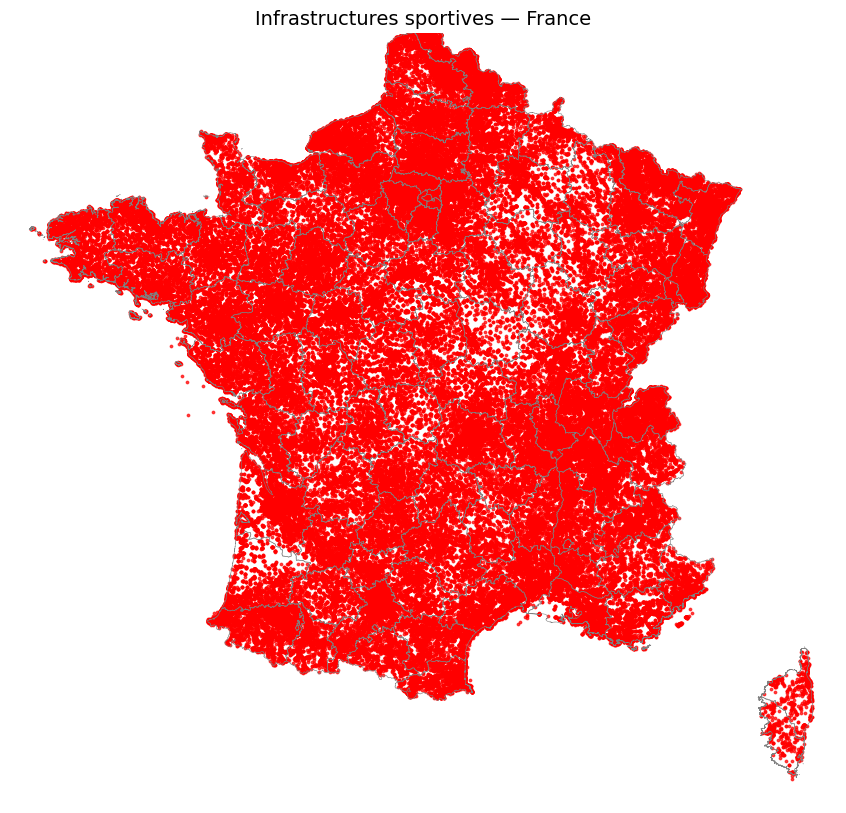

In [23]:
gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["Longitude"], df_final["Latitude"]),
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(20, 10))
gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.savefig('docs/premiere_carte.png', dpi=300, bbox_inches='tight')

On voit que le schéma de la "diagonale du vide" semble se reproduire avec les infrastructures sportives.
La densité des infrastructures sportives en Corse semble moins importante qu'en France métropolitaine.

In [24]:
#Carte de chaleur 


df = df_final.copy().dropna(subset=['Latitude', 'Longitude'])  #Supression des valeurs manquantes

#Création de la carte, centrée sur la France
calor = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='CartoDB positron'
)

#Récupération des données géographiques
heat_data = [[row['Latitude'], row['Longitude']] for idx, row in df.iterrows()]


#On complète la carte
HeatMap(
    heat_data,
    radius=15,           # Rayon de chaque point
    blur=20,             # Flou pour adoucir
    max_zoom=13,         # Zoom maximum
    gradient={            # Dégradé de couleurs personnalisé
        0.0: 'blue',
        0.3: 'lime',
        0.5: 'yellow',
        0.7: 'orange',
        1.0: 'red'
    }
).add_to(calor)
calor.save('docs/heatmap_toutes_infrastructures.html') #On sauvegarde la carte

In [25]:
#On crée une carte qui compte le nombre d'infrastructures sportives par département

infra_par_dept = df_final.copy().groupby('Département Code').size().reset_index(name='Nombre_infrastructures')

#On réadapte les codes de département pour correspondre au fond de carte
infra_par_dept['Département Code'] = infra_par_dept['Département Code'].astype(str)
infra_par_dept['Département Code'] = infra_par_dept['Département Code'].replace({
    '96': '2A',
    '97': '2B'
})

def format_dept_code(code):
    """
    Ajouter un zéro devant les codes à 1 chiffre (1 → 01)
    """
    if code in ['2A', '2B']:
        return code
    if int(code) >= 10:
        return code
    else:
        return "0" + code

infra_par_dept['Département Code'] = infra_par_dept['Département Code'].apply(format_dept_code)
print("-" * 50)
print("Visualisation de la base de données infra_par_dept")
print("-" * 50)
print(infra_par_dept.head(4))


gdf2 = gdf.copy() #On copie le fond de carte pour ne pas le modifier et pouvoir le réutiliser


gdf2 = gdf2.merge(               #Fusion des données
    infra_par_dept, 
    left_on='INSEE_DEP', 
    right_on='Département Code', 
    how='left'
)                 


#Création de la carte, centrée sur la France
m = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='CartoDB positron'
)

#On complète la carte
folium.Choropleth(
    geo_data=gdf2,
    name='choropleth',
    data=infra_par_dept,
    columns=['Département Code', 'Nombre_infrastructures'],
    key_on='feature.properties.INSEE_DEP',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Nombre d\'infrastructures sportives par département'
).add_to(m)

#Ajout des informations au survol de la souris
folium.GeoJson(
    gdf2,
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
    tooltip=folium.GeoJsonTooltip(
        fields=['INSEE_DEP', 'Nombre_infrastructures'],
        aliases=['Département:', 'Nombre d\'infrastructures:'],
        localize=True
    )
).add_to(m)
m.save('docs/carte_departements.html')

--------------------------------------------------
Visualisation de la base de données infra_par_dept
--------------------------------------------------
  Département Code  Nombre_infrastructures
0               01                    3853
1               02                    3165
2               03                    2183
3               04                    1576


On observe sur cette carte que la Moselle et le Nord sont les départements comptant le plus grand nombre d’infrastructures sportives, tandis que les deux départements corses en disposent nettement moins.
Cependant, cette lecture doit être nuancée : la carte ne tient pas compte du nombre d’habitants ni du revenu médian de chaque département, deux facteurs essentiels pour interpréter correctement ces écarts.
Observons maintenant l'effet de la population sur cette carte.

In [26]:
#Estimation du nombre d'habitants par département avec les communes disponibles dans la base de données
pop_par_dept = df_final.copy()[['Département Code', 'Commune INSEE', 'P22_POP']].drop_duplicates(
    subset=['Commune INSEE']
).groupby('Département Code')['P22_POP'].sum().reset_index()


pop_par_dept['Département Code'] = pop_par_dept['Département Code'].astype(str)
pop_par_dept['Département Code'] = pop_par_dept['Département Code'].replace({
    '96': '2A',
    '97': '2B'
})

pop_par_dept.columns = ['Département Code', 'Population_totale']
pop_par_dept['Département Code'] = pop_par_dept['Département Code'].apply(format_dept_code)

infra_par_dept = infra_par_dept.merge(pop_par_dept, on='Département Code', how='left')

infra_par_dept['Infra_pour_10k_hab'] = (
    infra_par_dept['Nombre_infrastructures'] / infra_par_dept['Population_totale'] * 10000
).round(2) #Calcul du nombre d'infrastructures pour 10000 habitants

print("-" * 50)
print("Visualisation de la base de données infra_par_dept")
print("-" * 50)
print(infra_par_dept.head(4))

gdf3 = gdf.copy()

gdf3 = gdf3.merge(
    infra_par_dept, 
    left_on='INSEE_DEP', 
    right_on='Département Code', 
    how='left'
)

n = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='CartoDB positron'
)

folium.Choropleth(
    geo_data=gdf3,
    name='choropleth',
    data=infra_par_dept,
    columns=['Département Code', 'Infra_pour_10k_hab'],
    key_on='feature.properties.INSEE_DEP',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Infrastructures sportives pour 10 000 habitants',
    nan_fill_color='lightgray'
).add_to(n)

folium.GeoJson(
    gdf3,
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
    tooltip=folium.GeoJsonTooltip(
        fields=['INSEE_DEP', 'Nombre_infrastructures', 'Population_totale', 'Infra_pour_10k_hab'],
        aliases=[
            'Département:', 
            'Nombre d\'infrastructures:', 
            'Population totale:',
            'Infrastructures / 10k hab:'
        ],
        localize=True
    )
).add_to(n)
n.save('docs/carte_infra_par_habitant.html')


--------------------------------------------------
Visualisation de la base de données infra_par_dept
--------------------------------------------------
  Département Code  Nombre_infrastructures  Population_totale  \
0               01                    3853           667641.0   
1               02                    3165           481628.0   
2               03                    2183           327604.0   
3               04                    1576           163403.0   

   Infra_pour_10k_hab  
0               57.71  
1               65.71  
2               66.64  
3               96.45  


Le résultat change totalement puisque c'est désormais les Hautes Alpes qui détiennent le plus d'infrastructures sportives par 10 000 habitants.

On va maintenant passer à des statistiques descriptives numériques 

In [31]:
print(f"Il y a {df_final["Type d'équipement sportif"].count()} infrastructures sportives dans notre base de données")

Il y a 281000 infrastructures sportives dans notre base de données


In [36]:
print("Voici le type d'infrastructures qu'on retrouve dans notre base de données : \n \n")
df_final.copy()["Type d'équipement sportif"].value_counts().reset_index().head(15)


Voici le type d'infrastructures qu'on retrouve dans notre base de données : 
 



,Type d'équipement sportif,count
0,Terrain de football,33294
1,Court de tennis,23231
2,Multisports/City-stades,22828
3,Boucle de randonnée,20815
4,Terrain de pétanque,17701
5,Salle multisports (gymnase),17348
6,Salles polyvalentes / des fêtes / non spécialisées,15320
7,Terrain de basket-ball,6992
8,Carrière,6789
9,Salle de musculation/cardiotraining,6774


In [43]:
infra_par_commune = (
    df_final.copy().groupby("Commune nom")
            .size()
            .reset_index(name="Nombre d'infrastructures")
)

infra_par_commune.describe()

,Nombre d'infrastructures
count,26820.000000
mean,10.477293
std,23.319842
min,1.000000
25%,2.000000
50%,5.000000
75%,11.000000
max,1399.000000


In [47]:
infra_par_commune.sort_values("Nombre d'infrastructures", ascending=False).head(10)

,Commune nom,Nombre d'infrastructures
24218,Toulouse,1399
18745,Reims,650
16122,Nantes,649
12273,Le Mans,508
15505,Montpellier,506
490,Angers,505
3273,Brest,504
23570,Strasbourg,497
6876,Dijon,451
16649,Nîmes,425


In [52]:
arrondissements_paris = df_final.copy()[
    df_final["Commune INSEE"].astype(str).between("75100", "75120")
]

infra_par_arrdt = (
    arrondissements_paris
    .groupby("Commune nom")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

infra_par_arrdt



,Commune nom,Nombre d'infrastructures
2,Paris 12e Arrondissement,336
6,Paris 16e Arrondissement,328
5,Paris 15e Arrondissement,243
3,Paris 13e Arrondissement,215
11,Paris 20e Arrondissement,207
4,Paris 14e Arrondissement,164
9,Paris 19e Arrondissement,152
1,Paris 11e Arrondissement,146
7,Paris 17e Arrondissement,139
8,Paris 18e Arrondissement,138


In [58]:
infra_par_dept.sort_values("Nombre_infrastructures", ascending=False)

,Département Code,Nombre_infrastructures,Population_totale,Infra_pour_10k_hab
57,59,7448,2601793.0,28.63
55,57,6670,1037748.0,64.27
29,31,5801,1436121.0,40.39
42,44,5725,1473156.0,38.86
62,64,5509,696235.0,79.13
...,...,...,...,...
56,58,974,176233.0,55.27
21,23,955,101536.0,94.06
88,90,706,136450.0,51.74
95,2B,663,173158.0,38.29


In [60]:
infra_par_dept.sort_values("Infra_pour_10k_hab", ascending=False)

,Département Code,Nombre_infrastructures,Population_totale,Infra_pour_10k_hab
4,05,3034,141282.0,214.75
46,48,1346,74717.0,180.15
8,09,1753,150086.0,116.80
14,15,1570,140786.0,111.52
30,32,1751,167587.0,104.48
...,...,...,...,...
12,13,4756,2069583.0,22.98
92,94,2400,1419531.0,16.91
90,92,2744,1647435.0,16.66
91,93,2340,1681725.0,13.91


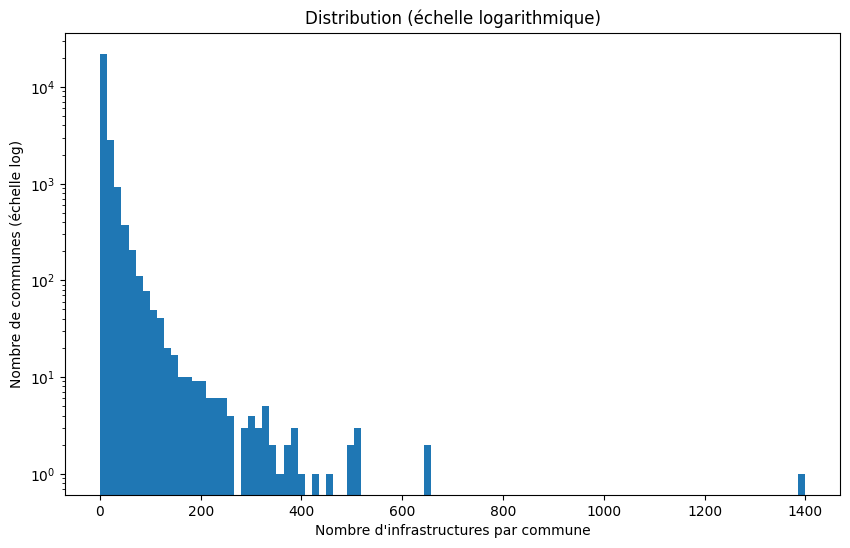

In [55]:
plt.figure(figsize=(10,6))
plt.hist(infra_par_commune["Nombre d'infrastructures"], bins=100)
plt.yscale("log")
plt.xlabel("Nombre d'infrastructures par commune")
plt.ylabel("Nombre de communes (échelle log)")
plt.title("Distribution (échelle logarithmique)")
plt.show()




In [ ]:
#Ca ressemble à une loi expo (ptet commenter dessus ?)

In [89]:
infra_par_densite = (
    df_final.copy().groupby("Densite Catégorie")
            .size()
            .reset_index(name="Nombre d'infrastructures")
)
infra_par_densite = infra_par_densite.sort_values("Nombre d'infrastructures", ascending=False)
infra_par_densite

,Densite Catégorie,Nombre d'infrastructures
5,Rural à habitat dispersé,72764
0,Bourgs ruraux,61889
3,Grands centres urbains,53458
2,Centres urbains intermédiaires,29792
1,Ceintures urbaines,26377
4,Petites villes,20152
6,Rural à habitat très dispersé,16569


In [91]:
df_med = infra_par_commune.merge(
    df_final.copy()[["Commune nom", "MED21"]],
    on= "Commune nom",
    how="left"
)


df_med["Quartile Revenu"] = pd.qcut(
    df_med["MED21"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile = (
    df_med.groupby("Quartile Revenu", observed = True)["Nombre d'infrastructures"]
            .mean()
            .reset_index()
)

infra_par_quartile.columns = ["Quartile Revenu", "Nombre d'infrastructures moyen par commune"]
infra_par_quartile

,Quartile Revenu,Nombre d'infrastructures moyen par commune
0,Q1,81.594128
1,Q2,90.477661
2,Q3,40.321115
3,Q4,39.758931


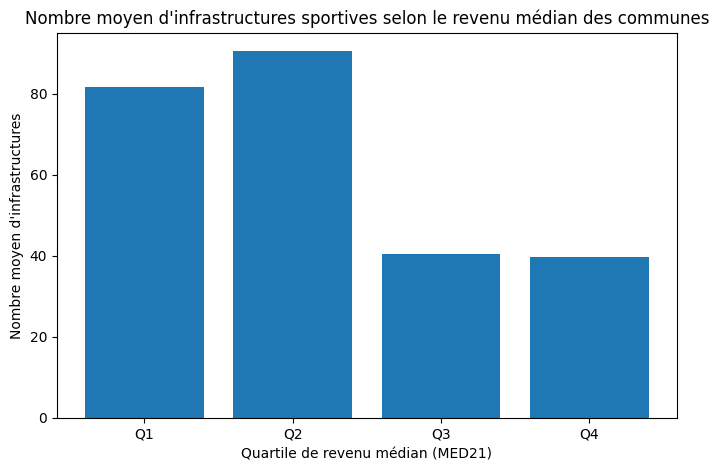

In [76]:
plt.figure(figsize=(8,5))
plt.bar(infra_par_quartile["Quartile Revenu"], infra_par_quartile["Nombre d'infrastructures moyen par commune"])
plt.xlabel("Quartile de revenu médian (MED21)")
plt.ylabel("Nombre moyen d'infrastructures")
plt.title("Nombre moyen d'infrastructures sportives selon le revenu médian des communes")
plt.show()

In [78]:
df_chom = infra_par_commune.merge(
    df_final.copy()[["Commune nom", "P22_CHOM1564"]],
    on= "Commune nom",
    how="left"
)


df_chom["Quartile Chômage"] = pd.qcut(
    df_chom["P22_CHOM1564"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile_chom = (
    df_chom.groupby("Quartile Chômage", observed = True)["Nombre d'infrastructures"]
            .mean()
            .reset_index()
)

infra_par_quartile_chom.columns = ["Quartile Chômage", "Nombre d'infrastructures moyen par commune"]
infra_par_quartile_chom

,Quartile Chômage,Nombre d'infrastructures moyen par commune
0,Q1,9.568219
1,Q2,15.854036
2,Q3,36.328346
3,Q4,187.880258


In [79]:
#Bizarre (regarder plus précisemment maybe)

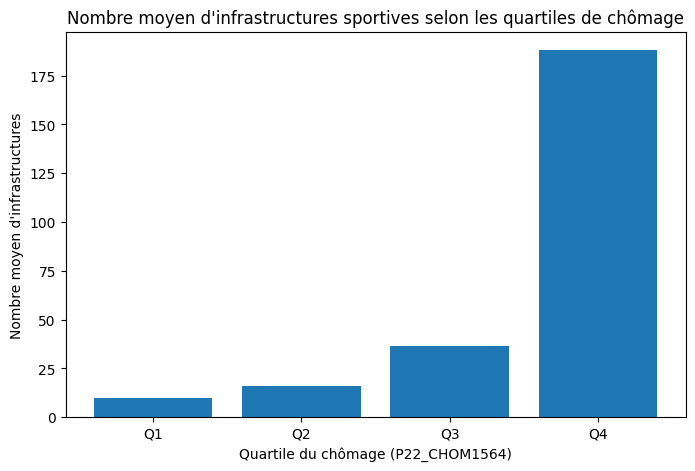

In [82]:
plt.figure(figsize=(8,5))
plt.bar(infra_par_quartile_chom["Quartile Chômage"], infra_par_quartile_chom["Nombre d'infrastructures moyen par commune"])
plt.xlabel("Quartile du chômage (P22_CHOM1564)")
plt.ylabel("Nombre moyen d'infrastructures")
plt.title("Nombre moyen d'infrastructures sportives selon les quartiles de chômage")
plt.show()

In [92]:
df_pol = infra_par_commune.merge(
    df_final.copy()[["Commune nom", "Nuance candidat élu"]],
    on= "Commune nom",
    how="left"
)


infra_par_pol= (
    df_pol.groupby("Nuance candidat élu", observed = True)["Nombre d'infrastructures"]
            .mean()
            .reset_index()
)

infra_par_pol.columns = ["Nuance du candidat élu", "Nombre d'infrastructures moyen par commune"]
infra_par_pol = infra_par_pol.sort_values("Nombre d'infrastructures moyen par commune", ascending=False)
infra_par_pol

,Nuance du candidat élu,Nombre d'infrastructures moyen par commune
0,DIV,128.805486
11,UG,97.749257
6,HOR,83.287982
3,DVG,64.645161
5,ENS,62.642387
12,UXD,60.994285
9,RN,39.375748
10,UDI,36.576923
1,DVC,35.471865
7,LR,33.740604


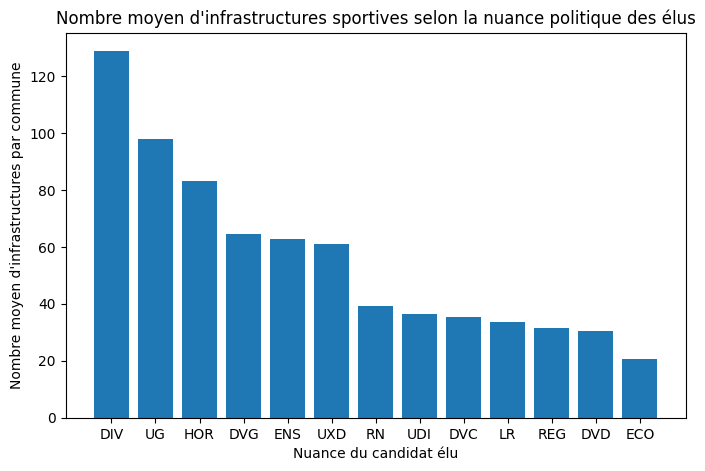

In [94]:
plt.figure(figsize=(8,5))
plt.bar(infra_par_pol["Nuance du candidat élu"], infra_par_pol["Nombre d'infrastructures moyen par commune"])
plt.xlabel("Nuance du candidat élu")
plt.ylabel("Nombre moyen d'infrastructures par commune")
plt.title("Nombre moyen d'infrastructures sportives selon la nuance politique des élus")
plt.show()

In [ ]:
#Peut être faire une fonction pour les barplots (code redondant) et même peut être pour les groupby
#précédants mais plus dur

In [ ]:
!nb-clean clean Projet.ipynb

In [ ]:
!ls -lh Projet.ipynb